In [22]:
from helper import *
import os, os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from astropy.coordinates import Angle, SkyCoord
import astropy.units as u

import seaborn as sns

from sklearn.cluster import DBSCAN, OPTICS,  cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import KernelDensity

from scipy.stats import multivariate_normal, uniform
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
%matplotlib inline

from helpers import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#load in the background data
sim_dir = './'
srcname = '1902'
background = []
signal = []

num_inj_events = np.linspace(20, 200, num=19)
num_inj_events = [f"{num:03.0f}" for num in num_inj_events]

for bkgfile in sorted(glob.glob(sim_dir+srcname+'/bkg/*.npy')):
    b = np.load(bkgfile, allow_pickle=True)
    print(bkgfile)
    background.append(b)

for sigfile in sorted(glob.glob(sim_dir+srcname+'/sig/*.npy')):
    s = np.load(sigfile, allow_pickle=True)
    print(sigfile)
    signal.append(s)

./1902/bkg/1902_bkg_ninj020.npy
./1902/bkg/1902_bkg_ninj030.npy
./1902/bkg/1902_bkg_ninj040.npy
./1902/bkg/1902_bkg_ninj050.npy
./1902/bkg/1902_bkg_ninj060.npy
./1902/bkg/1902_bkg_ninj070.npy
./1902/bkg/1902_bkg_ninj080.npy
./1902/bkg/1902_bkg_ninj090.npy
./1902/bkg/1902_bkg_ninj100.npy
./1902/bkg/1902_bkg_ninj110.npy
./1902/bkg/1902_bkg_ninj120.npy
./1902/bkg/1902_bkg_ninj130.npy
./1902/bkg/1902_bkg_ninj140.npy
./1902/bkg/1902_bkg_ninj150.npy
./1902/bkg/1902_bkg_ninj160.npy
./1902/bkg/1902_bkg_ninj170.npy
./1902/bkg/1902_bkg_ninj180.npy
./1902/bkg/1902_bkg_ninj190.npy
./1902/bkg/1902_bkg_ninj200.npy
./1902/sig/1902_sig_ninj020.npy
./1902/sig/1902_sig_ninj030.npy
./1902/sig/1902_sig_ninj040.npy
./1902/sig/1902_sig_ninj050.npy
./1902/sig/1902_sig_ninj060.npy
./1902/sig/1902_sig_ninj070.npy
./1902/sig/1902_sig_ninj080.npy
./1902/sig/1902_sig_ninj090.npy
./1902/sig/1902_sig_ninj100.npy
./1902/sig/1902_sig_ninj110.npy
./1902/sig/1902_sig_ninj120.npy
./1902/sig/1902_sig_ninj130.npy
./1902/s

In [15]:
# #use signal-injection (turn off for real data)
use_sig=True

###Load bkg events in degrees

bkg_ra_list = []
bkg_dec_list = []
for i in range(len(background)):
    bkg_ra, bkg_dec = load_events(background[i])
    bkg_ra_list.append(bkg_ra)
    bkg_dec_list.append(bkg_dec)
    print("Number of bkg events loaded from {} injected events = {}".format(num_inj_events[i],len(bkg_dec)))

###Load signal events in degrees
signal_ra_list = []
signal_dec_list = []
if use_sig:
    for i in range(len(signal)):
        sig_ra, sig_dec = load_events(signal[i])
        signal_ra_list.append(sig_ra)
        signal_dec_list.append(sig_dec)
        print("Number of Signal events loaded from {} injected events = {}".format(num_inj_events[i],len(sig_dec)))

Number of bkg events loaded from 020 injected events = 186858
Number of bkg events loaded from 030 injected events = 186858
Number of bkg events loaded from 040 injected events = 186858
Number of bkg events loaded from 050 injected events = 186858
Number of bkg events loaded from 060 injected events = 186858
Number of bkg events loaded from 070 injected events = 186858
Number of bkg events loaded from 080 injected events = 186858
Number of bkg events loaded from 090 injected events = 186858
Number of bkg events loaded from 100 injected events = 186858
Number of bkg events loaded from 110 injected events = 186858
Number of bkg events loaded from 120 injected events = 186858
Number of bkg events loaded from 130 injected events = 186858
Number of bkg events loaded from 140 injected events = 186858
Number of bkg events loaded from 150 injected events = 186858
Number of bkg events loaded from 160 injected events = 186858
Number of bkg events loaded from 170 injected events = 186858
Number o

In [16]:
######Convert to Radians
bkg_ra_rad_list = []
bkg_dec_rad_list = []
for i in range(len(bkg_ra_list)):
    bkg_ra_rad=ra_deg_to_rad(bkg_ra_list[i])
    bkg_dec_rad=dec_deg_to_rad(bkg_dec_list[i])
    bkg_ra_rad_list.append(bkg_ra_rad)
    bkg_dec_rad_list.append(bkg_dec_rad)
signal_ra_rad_list = []
signal_dec_rad_list = []
for i in range(len(signal_ra_list)):
    signal_ra_rad=ra_deg_to_rad(signal_ra_list[i])
    signal_dec_rad=dec_deg_to_rad(signal_dec_list[i])
    signal_ra_rad_list.append(signal_ra_rad)
    signal_dec_rad_list.append(signal_dec_rad)

In [23]:
#######Crop data to include only events in ROI#######

coord_sys = 'G'
# xyrange = [350, 10, -10, 10]  #l1,l2, b1, b2
l_center=40
b_center=0
x_width = 10
y_width = 8
origin = [l_center, b_center, x_width, y_width] #l, b, length, width
convert_to_cel=True

###Select 20 events
bkg_ra, bkg_dec = bkg_ra_list[0],  bkg_dec_list[0]
sig_ra, sig_dec = signal_ra_list[0], signal_dec_list[0]
bkg_ra_rad, bkg_dec_rad = bkg_ra_rad_list[0], bkg_dec_rad_list[0]
sig_ra_rad, sig_dec_rad = signal_ra_rad_list[0], signal_dec_rad_list[0]

bkg_ra_roi_list =[]
bkg_dec_roi_list = []

for i in range(len(bkg_ra_list)):
    bkg_ra_roi, bkg_dec_roi = select_event_roi(bkg_ra_list[i], bkg_dec_list[i], origin, coord_sys, convert_to_cel)
    bkg_ra_roi_list.append(bkg_ra_roi)
    bkg_dec_roi_list.append(bkg_dec_roi)
    print(r"Length of background events: Total={}  /  ROI = {}".format(len(bkg_ra_rad), len(bkg_ra_roi)))

sig_ra_roi_list = []
sig_dec_roi_list = []
for i in range(len(bkg_ra_list)):
    sig_ra_roi, sig_dec_roi = select_event_roi(signal_ra_list[i], signal_dec_list[i], origin, coord_sys, convert_to_cel)
    sig_ra_roi_list.append(sig_ra_roi)
    sig_dec_roi_list.append(sig_dec_roi)
    print(r"Length of Signal events: Total={}  /  ROI = {}".format(len(signal_ra_list[i]), len(sig_ra_roi)))


Length of background events: Total=186858  /  ROI = 11757
Length of background events: Total=186858  /  ROI = 11744
Length of background events: Total=186858  /  ROI = 11786
Length of background events: Total=186858  /  ROI = 11605
Length of background events: Total=186858  /  ROI = 11690
Length of background events: Total=186858  /  ROI = 11598
Length of background events: Total=186858  /  ROI = 11751
Length of background events: Total=186858  /  ROI = 11820
Length of background events: Total=186858  /  ROI = 11677
Length of background events: Total=186858  /  ROI = 11707
Length of background events: Total=186858  /  ROI = 11933
Length of background events: Total=186858  /  ROI = 11683
Length of background events: Total=186858  /  ROI = 11724
Length of background events: Total=186858  /  ROI = 11624
Length of background events: Total=186858  /  ROI = 11708
Length of background events: Total=186858  /  ROI = 11640
Length of background events: Total=186858  /  ROI = 11635
Length of back

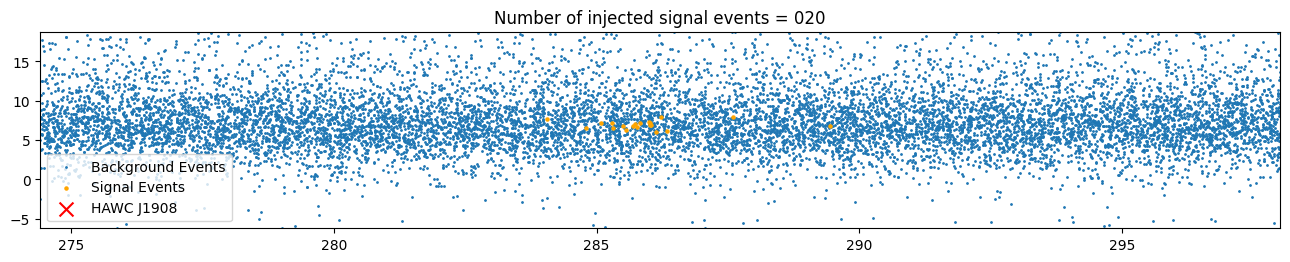

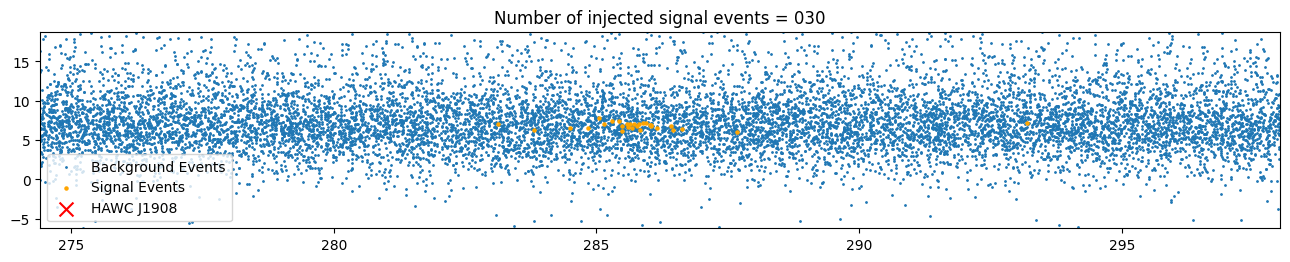

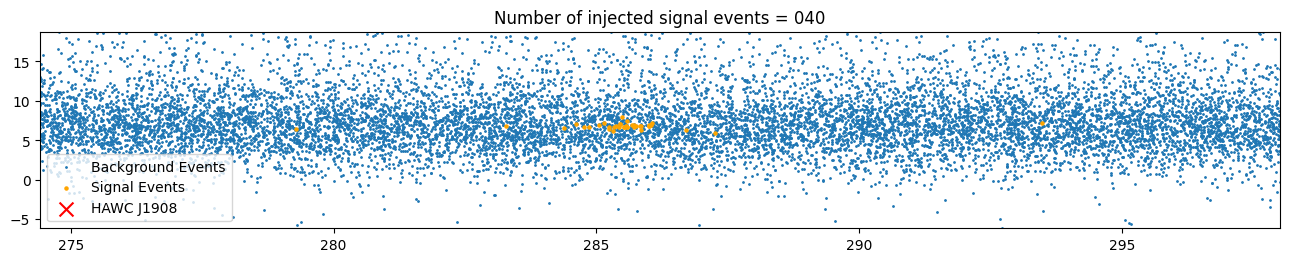

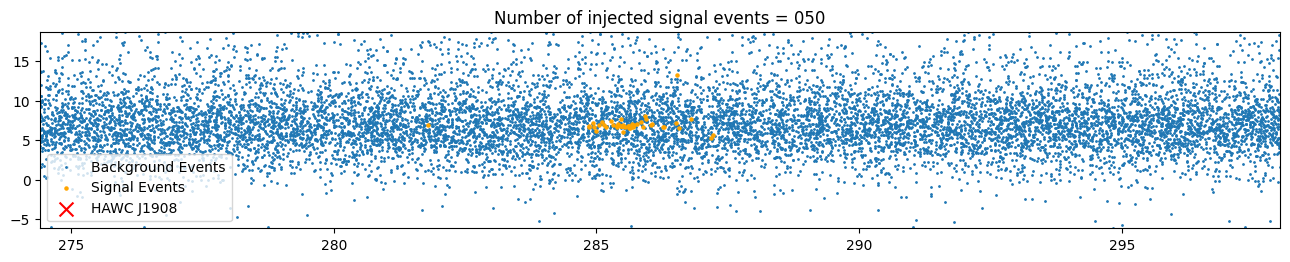

In [26]:
for i in range(4):
    bkg_ra_roi = bkg_ra_roi_list[i]
    bkg_dec_roi = bkg_dec_roi_list[i]
    sig_ra_roi = sig_ra_roi_list[i]
    sig_dec_roi = sig_dec_roi_list[i]
    xmin, xmax = np.min(bkg_ra_roi), np.max(bkg_ra_roi)
    ymin, ymax= np.min(bkg_dec_roi), np.max(bkg_dec_roi)
    fig = plt.figure(figsize=(16, 24))
    ax1 = fig.add_subplot(8, 1, i+1)
    background = ax1.scatter(bkg_ra_roi, bkg_dec_roi, s=1, label='Background Events')
    signal = ax1.scatter(sig_ra_roi, sig_dec_roi, s=5, label='Signal Events', color='orange')
    ax1.scatter(np.pi-5.01345828,0.1083849, marker='x', s=100, color='red', label='HAWC J1908')
    ax1.legend(loc='lower left')
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_title('Number of injected signal events = {}'.format(num_inj_events[i]))

In [27]:
#Inject Source events into bkg#
inj_ra_list = []
inj_dec_list = []
for i in range(len(bkg_ra_roi_list)):
    inj_ra = []
    inj_dec = []
    inj_ra=bkg_ra_roi_list[i].copy()
    inj_dec=bkg_dec_roi_list[i].copy()
    for j in range(len(sig_ra_roi_list[i])):
        # print(len(sig_ra_roi_list[i]))
        inj_ra.append(sig_ra_roi_list[i][j])
        inj_dec.append(sig_dec_roi_list[i][j])
    inj_ra_list.append(inj_ra)
    inj_dec_list.append(inj_dec)

    print("Number of events: Background = {} | Signal={} | Injection={}".format(len(bkg_ra_roi_list[i]), len(sig_ra_roi_list[i]), len(inj_ra_list[i])))

Number of events: Background = 11757 | Signal=20 | Injection=11777
Number of events: Background = 11744 | Signal=29 | Injection=11773
Number of events: Background = 11786 | Signal=39 | Injection=11825
Number of events: Background = 11605 | Signal=50 | Injection=11655
Number of events: Background = 11690 | Signal=60 | Injection=11750
Number of events: Background = 11598 | Signal=70 | Injection=11668
Number of events: Background = 11751 | Signal=79 | Injection=11830
Number of events: Background = 11820 | Signal=89 | Injection=11909
Number of events: Background = 11677 | Signal=100 | Injection=11777
Number of events: Background = 11707 | Signal=106 | Injection=11813
Number of events: Background = 11933 | Signal=119 | Injection=12052
Number of events: Background = 11683 | Signal=127 | Injection=11810
Number of events: Background = 11724 | Signal=140 | Injection=11864
Number of events: Background = 11624 | Signal=149 | Injection=11773
Number of events: Background = 11708 | Signal=159 | Inje

In [28]:
#Inject Source events into bkg#
inj_ra_list = []
inj_dec_list = []
m = 0
for i, j, k, l in zip(bkg_ra_roi_list, bkg_dec_roi_list, sig_ra_roi_list, sig_dec_roi_list):
    inj_ra = []
    inj_dec = []
    inj_ra=i.copy()
    inj_dec=j.copy()
    for n in range(len(k)):
        inj_ra.append(k[n])
        inj_dec.append(l[n])
    inj_ra_list.append(inj_ra)
    inj_dec_list.append(inj_dec)
    print("Number of events: Background = {} | Signal={} | Injection={}".format(len(i), len(k), len(inj_ra_list[m])))
    m = m+1

Number of events: Background = 11757 | Signal=20 | Injection=11777
Number of events: Background = 11744 | Signal=29 | Injection=11773
Number of events: Background = 11786 | Signal=39 | Injection=11825
Number of events: Background = 11605 | Signal=50 | Injection=11655
Number of events: Background = 11690 | Signal=60 | Injection=11750
Number of events: Background = 11598 | Signal=70 | Injection=11668
Number of events: Background = 11751 | Signal=79 | Injection=11830
Number of events: Background = 11820 | Signal=89 | Injection=11909
Number of events: Background = 11677 | Signal=100 | Injection=11777
Number of events: Background = 11707 | Signal=106 | Injection=11813
Number of events: Background = 11933 | Signal=119 | Injection=12052
Number of events: Background = 11683 | Signal=127 | Injection=11810
Number of events: Background = 11724 | Signal=140 | Injection=11864
Number of events: Background = 11624 | Signal=149 | Injection=11773
Number of events: Background = 11708 | Signal=159 | Inje

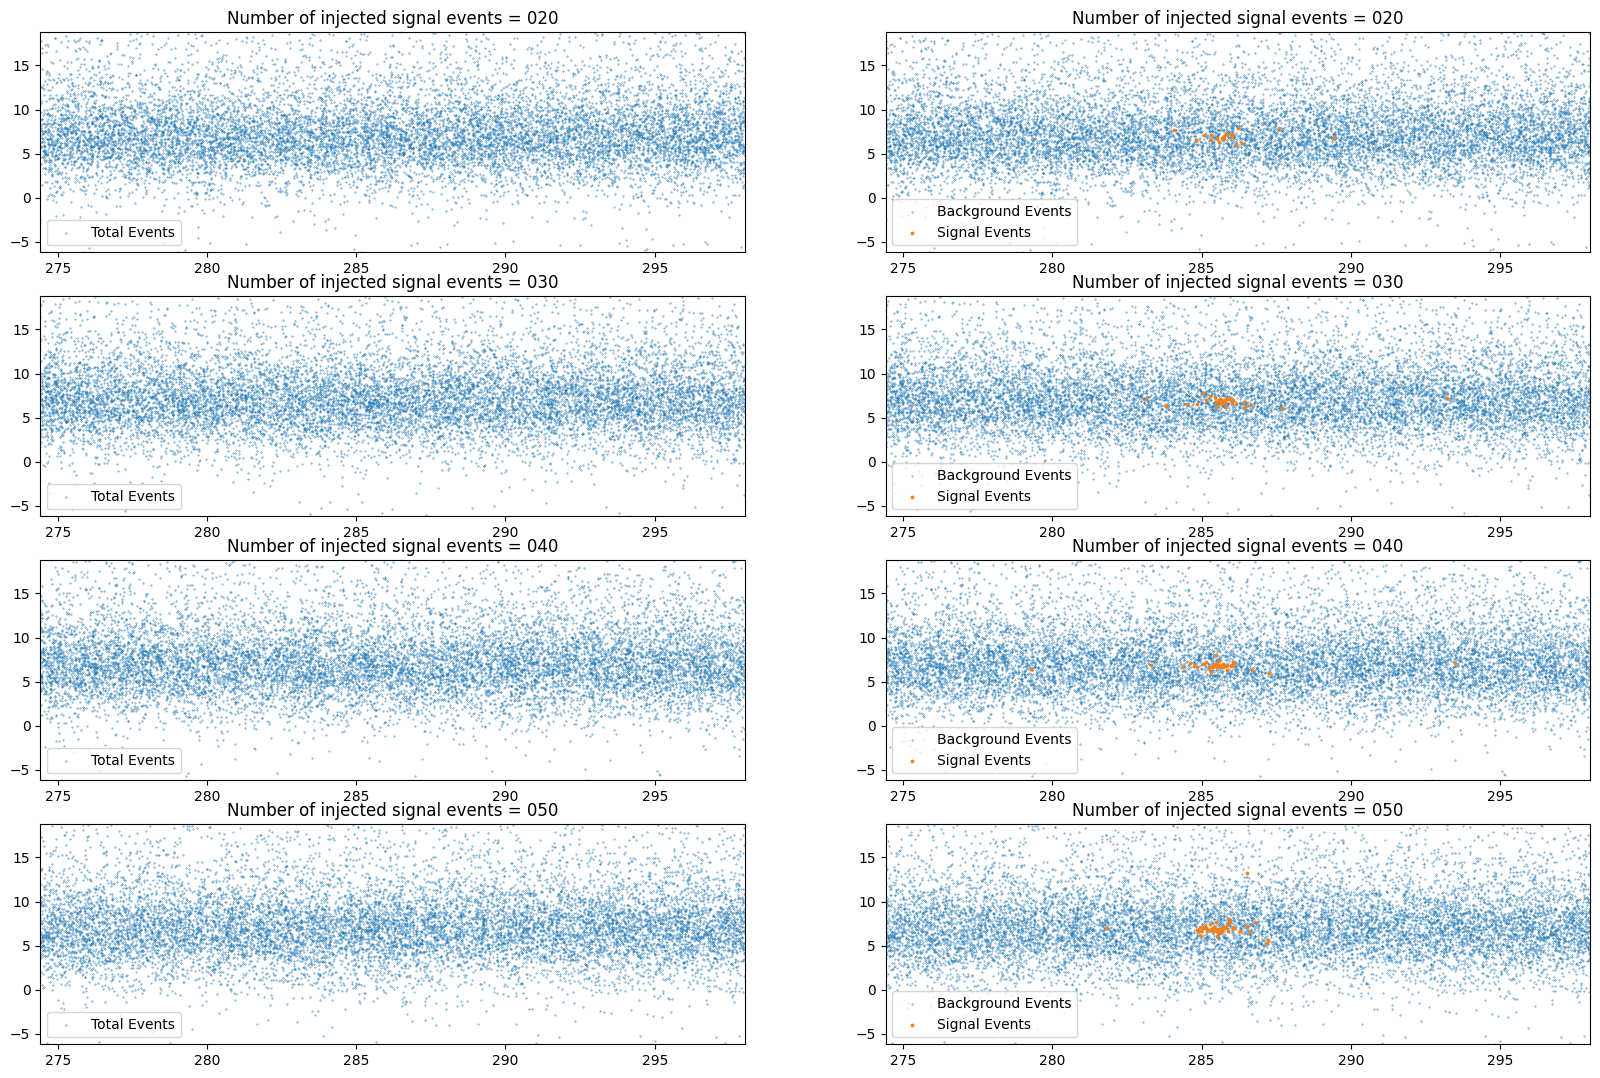

In [29]:
fig = plt.figure(figsize=(20,20))
j = 1
for i in range(4):
    ax1 = fig.add_subplot(6, 2, j)
    background = ax1.scatter(inj_ra_list[i], inj_dec_list[i], s=0.1, label='Total Events')
    ax1.legend(loc='lower left')
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_title('Number of injected signal events = {}'.format(num_inj_events[i]))
    j=j+1
    ax2 = fig.add_subplot(6, 2, j)
    background = ax2.scatter(bkg_ra_roi_list[i], bkg_dec_roi_list[i], s=0.1, label='Background Events')
    signal = ax2.scatter(sig_ra_roi_list[i], sig_dec_roi_list[i], s=3, label='Signal Events')
    ax2.legend(loc='lower left')
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_title('Number of injected signal events = {}'.format(num_inj_events[i]))
    j=j+1

In [52]:
# Choose one eps and min_samples value to test
eps = 0.5
min_samples = 20

# Assuming bkg_ra_roi_list[i] and bkg_dec_roi_list[i] exist for i=0
i = 9

# Background events
bkg_events = np.vstack([bkg_ra_roi_list[i], bkg_dec_roi_list[i]]).T
bkg_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
bkg_labels = bkg_dbscan.fit_predict(bkg_events)
n_clusters_bkg = len(set(bkg_labels)) - (1 if -1 in bkg_labels else 0)
print(f"Background: Found {n_clusters_bkg} clusters with eps={eps}, min_samples={min_samples}")

# Injected events
inj_events = np.vstack([inj_ra_list[i], inj_dec_list[i]]).T
inj_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
inj_labels = inj_dbscan.fit_predict(inj_events)
n_clusters_inj = len(set(inj_labels)) - (1 if -1 in inj_labels else 0)
print(f"Injected: Found {n_clusters_inj} clusters with eps={eps}, min_samples={min_samples}")

Background: Found 8 clusters with eps=0.5, min_samples=20
Injected: Found 8 clusters with eps=0.5, min_samples=20


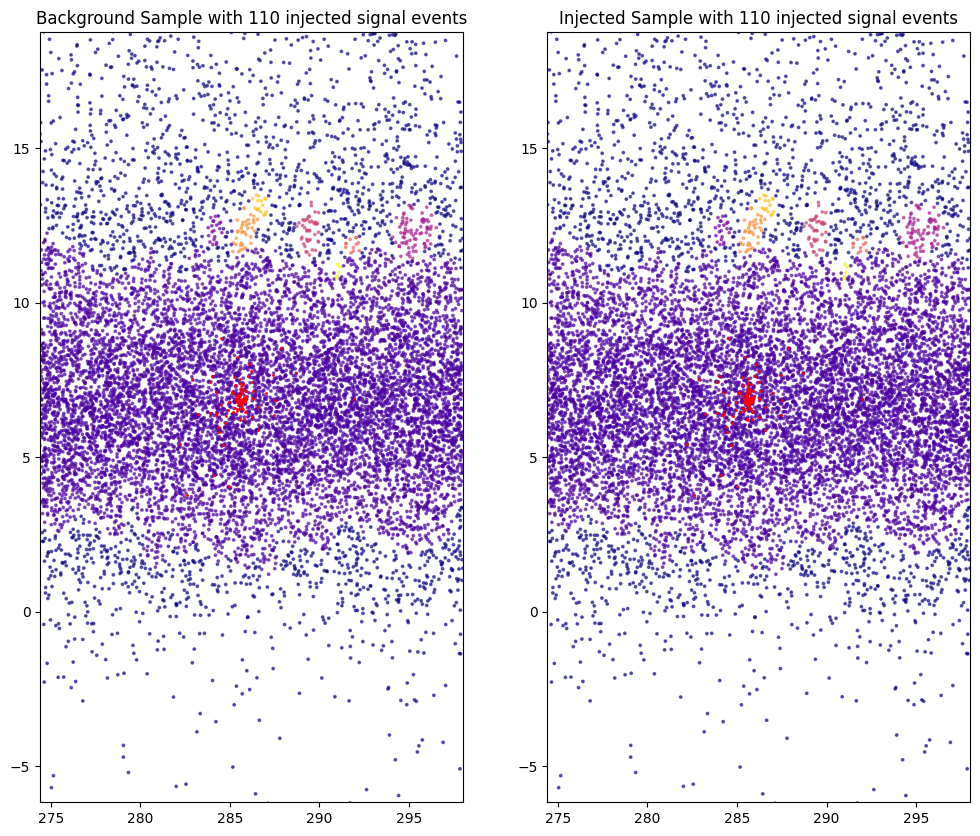

In [53]:
i = 9

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(1, 2, 1)
# ax1.scatter(bkg_ra_roi_list[i], bkg_dec_roi_list[i], s=1, label='Total Events', color='gray')
ax1.scatter(bkg_ra_roi_list[i], bkg_dec_roi_list[i], c=bkg_labels, s=3, alpha=0.6, cmap='plasma')
ax1.scatter(sig_ra_roi_list[i], sig_dec_roi_list[i], s=1, label='Signal Events', color='red')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.set_title(f'Background Sample with {num_inj_events[i]} injected signal events')

ax2 = fig.add_subplot(1, 2, 2)
# ax2.scatter(inj_ra_list[i], inj_dec_list[i], s=1, label='Background Events', color='gray')
ax2.scatter(inj_ra_list[i], inj_dec_list[i], c=inj_labels, s=3, alpha=0.6, cmap='plasma')
ax2.scatter(sig_ra_roi_list[i], sig_dec_roi_list[i], s=1, label='Signal Events', color='red')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_title(f'Injected Sample with {num_inj_events[i]} injected signal events')

plt.show()
